In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count
from tqdm import tqdm


In [3]:
train = pd.read_csv("../data/santander_data/train.csv")
test = pd.read_csv("../data/santander_data/test.csv")

In [4]:
df_train = train.copy()
df_test = test.copy()

In [5]:
df_train.loc[df_train.target==1,'ID_code'].count()/df_train.loc[df_train.target==0,'ID_code'].count()

0.1117163789174106

In [6]:
df_train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

### Remove fake data from test data

In [7]:
# te_ = test.copy()
# te_ = te_.iloc[:, 1:].values  # remove id

# unique_count = np.zeros_like(te_)

# for col in range(te_.shape[1]):
#     _, index_, count_ = np.unique(te_[:,col], return_counts=True, return_index = True)
    
#     unique_count[index_[count_==1], col] += 1
    
# real_te_idx = np.argwhere(np.sum(unique_count, axis=1) > 0)[:,0]
# syn_te_idx = np.argwhere(np.sum(unique_count, axis=1) == 0)[:,0]

In [8]:
X_train = df_train.iloc[:,2:].values
y_train = df_train.iloc[:,1].values

X_test = df_test.iloc[:,1:].values

X = np.concatenate([X_train, X_test])

In [9]:
X.shape

(400000, 200)

In [14]:
# X는 numpy array (dataframe이 아니다)
X

array([[  8.9255,  -6.7863,  11.9081, ...,   8.5635,  12.7803,  -1.0914],
       [ 11.5006,  -4.1473,  13.8588, ...,   8.7889,  18.356 ,   1.9518],
       [  8.6093,  -2.7457,  12.0805, ...,   8.2675,  14.7222,   0.3965],
       ...,
       [ 11.636 ,   2.2769,  11.2074, ...,   9.1933,  11.7905, -22.2762],
       [ 13.5745,  -0.5134,  13.6584, ...,   8.1079,   8.7735,  -0.2122],
       [ 10.4664,   1.807 ,  10.2277, ...,  10.3378,  14.334 ,  -7.7094]])

In [17]:
print(type(X))

<class 'numpy.ndarray'>


In [27]:
# refer to conditional prob
reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                
                ]

In [28]:
for i in reverse_list:
    X[:,i] *= -1

In [29]:
# 변환하고 난 후 데이터 비교하기
train.drop(['ID_code','target'], axis=1).head(3)

var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200   
1  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468   
2   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155 -4.9193   

    var_9  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  5.7470  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  8.0851  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2  5.9525  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  

[3 rows x 200 columns]

In [31]:
# numpy.ndarray --> dataframe 해서 들여다 보기
# reverse_list에 포함된 컬럼들의 부호가 바뀐 것을 확인할 수 있다 
X_df = pd.DataFrame(X, columns=test.drop('ID_code', axis=1).columns)
X_df.head(3)

var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0  -8.9255  6.7863 -11.9081 -5.0930 -11.4607  9.2834 -5.1187 -18.6266  4.9200   
1 -11.5006  4.1473 -13.8588 -5.3890 -12.3622 -7.0433 -5.6208 -16.5338 -3.1468   
2  -8.6093  2.7457 -12.0805 -7.8928 -10.5825  9.0837 -6.9427 -14.6155  4.9193   

    var_9  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  5.7470  ...  -4.4354  -3.9642   3.1364   1.6910  18.5227   2.3978  -7.8784   
1  8.0851  ...  -7.6421  -7.7214   2.5837  10.9516  15.4305  -2.0339  -8.1267   
2  5.9525  ...  -2.9057  -9.7905   1.6704   1.6858  21.6042  -3.1417   6.5213   

   var_197  var_198  var_199  
0   8.5635  12.7803   1.0914  
1   8.7889  18.3560  -1.9518  
2   8.2675  14.7222  -0.3965  

[3 rows x 200 columns]

In [32]:
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [34]:
# StandardScaler에 의해서, -3 ~ +3 사이정도의 값을 가지게 되겠지...
pd.DataFrame(X, columns=test.drop('ID_code', axis=1).columns).head(3)

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0  0.573930  1.275655 -0.453774  0.829761 -0.236655  0.537163  0.338885   
1 -0.273590  0.623288 -1.193406  0.685231 -0.793204 -1.538372 -0.241141   
2  0.677998  0.276809 -0.519141 -0.537312  0.305510  0.511776 -1.768200   

      var_7     var_8     var_9  ...   var_190   var_191   var_192   var_193  \
0 -0.610620  1.560352 -1.476589  ... -0.268524  1.152071  0.817682 -0.409608   
1  0.001080 -0.859932  0.418964  ... -0.972423 -0.090291  0.444032  1.909132   
2  0.561777  1.560142 -1.309985  ...  0.067258 -0.774463 -0.173400 -0.410910   

    var_194   var_195   var_196   var_197   var_198   var_199  
0  0.168050  1.580891 -1.024023 -0.376431 -1.026522 -0.210689  
1 -0.817386 -1.519224 -1.069580 -0.131768  0.825978 -0.502789  
2  1.150076 -2.294165  1.617955 -0.697728 -0.381335 -0.353504  

[3 rows x 200 columns]

(array([3.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+01, 1.4370e+03,
        4.1170e+03, 4.6270e+03, 5.8040e+03, 7.6920e+03, 1.0905e+04,
        1.5185e+04, 2.1430e+04, 2.9574e+04, 3.1439e+04, 3.2720e+04,
        3.5057e+04, 3.6484e+04, 3.6067e+04, 3.3922e+04, 3.0031e+04,
        2.3839e+04, 1.7337e+04, 1.1060e+04, 6.1080e+03, 3.0920e+03,
        1.3450e+03, 4.8000e+02, 1.4900e+02, 4.5000e+01, 8.0000e+00]),
 array([-3.83560271, -3.59276942, -3.34993613, -3.10710285, -2.86426956,
        -2.62143627, -2.37860299, -2.1357697 , -1.89293641, -1.65010312,
        -1.40726984, -1.16443655, -0.92160326, -0.67876998, -0.43593669,
        -0.1931034 ,  0.04972989,  0.29256317,  0.53539646,  0.77822975,
         1.02106303,  1.26389632,  1.50672961,  1.7495629 ,  1.99239618,
         2.23522947,  2.47806276,  2.72089604,  2.96372933,  3.20656262,
         3.44939591]),
 <a list of 30 Patch objects>)

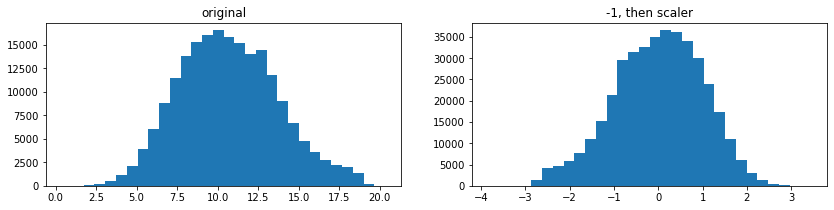

In [46]:
# 원본 histogram과 변경된 X의 histogram을 살펴보자
# 
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
ax1.set_title('original')
ax1.hist(train['var_0'], bins=30)
ax2.set_title('-1, then scaler')
ax2.hist(X[:,0], bins=30)

(array([7.0000e+00, 5.2000e+02, 2.3110e+03, 2.9140e+03, 4.0790e+03,
        6.1420e+03, 9.2150e+03, 1.3556e+04, 1.7286e+04, 2.0290e+04,
        2.1995e+04, 2.3236e+04, 2.3512e+04, 2.3496e+04, 2.3749e+04,
        2.9451e+04, 2.3637e+04, 2.2835e+04, 2.4856e+04, 2.5888e+04,
        2.5649e+04, 2.2092e+04, 1.5894e+04, 9.8980e+03, 4.7980e+03,
        1.8400e+03, 6.8600e+02, 1.4300e+02, 2.0000e+01, 5.0000e+00]),
 array([-2.91683883, -2.72280296, -2.5287671 , -2.33473123, -2.14069537,
        -1.94665951, -1.75262364, -1.55858778, -1.36455192, -1.17051605,
        -0.97648019, -0.78244432, -0.58840846, -0.3943726 , -0.20033673,
        -0.00630087,  0.18773499,  0.38177086,  0.57580672,  0.76984258,
         0.96387845,  1.15791431,  1.35195018,  1.54598604,  1.7400219 ,
         1.93405777,  2.12809363,  2.32212949,  2.51616536,  2.71020122,
         2.90423709]),
 <a list of 30 Patch objects>)

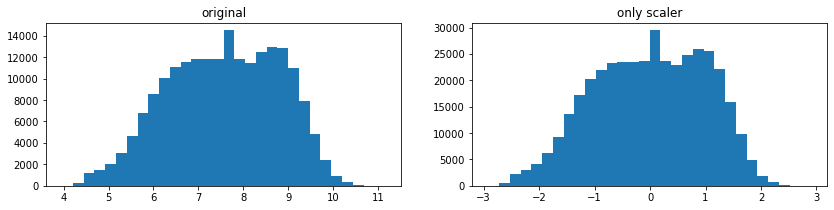

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
ax1.set_title('original')
ax1.hist(train['var_9'], bins=30)
ax2.set_title('only scaler')
ax2.hist(X[:,9], bins=30)

In [48]:
# count encoding
var_len = X.shape[1]
X_cnt = np.zeros((len(X), var_len*4))  # X가 400k, 200인데 --> 400k, 800으로 텅빈 ndarray를 만들고..

# X_cnt에 값을 셋팅. 200번 x 4번 for loop 돌아서, 800개 컬럼값을 채울 수 있게
for j in range(var_len):
    for i in range(1,4):
        x = np.round(X[:,j], i+1)
        dic = pd.value_counts(x).to_dict()
        X_cnt[:, j*4+i] = pd.Series(x).map(dic)
    
    x = X[:,j]
    dic = pd.value_counts(x).to_dict()
    X_cnt[:,j*4] = pd.Series(x).map(dic)
        
    

In [60]:
# 위의 for loop를 output 가지고 설명을 하자면...
# 최종 dic 에 들어가는 값은 
j=0 # 즉, var_0 필드에 해당
i=0
x = np.round(X[:,j], i+1)
dic = pd.value_counts(x).to_dict()
dic

{0.2: 15167,
 0.3: 15110,
 0.4: 14809,
 0.1: 14790,
 0.5: 14771,
 -0.0: 14529,
 -0.1: 14465,
 0.6: 14151,
 -0.2: 14021,
 -0.7: 13806,
 0.7: 13754,
 -0.3: 13628,
 -0.6: 13242,
 0.8: 13064,
 -0.4: 12943,
 0.9: 12425,
 -0.5: 12380,
 -0.8: 12287,
 1.0: 11750,
 -0.9: 10334,
 1.1: 10271,
 1.2: 9079,
 -1.0: 9056,
 -1.1: 8457,
 1.3: 8063,
 -1.2: 7066,
 1.4: 6996,
 -1.3: 6027,
 1.5: 5849,
 -1.4: 5395,
 1.6: 4729,
 -1.5: 4714,
 -1.6: 4002,
 1.7: 3930,
 -1.7: 3453,
 -1.8: 3117,
 1.8: 3032,
 -1.9: 2656,
 -2.0: 2372,
 1.9: 2265,
 -2.1: 2192,
 -2.2: 1981,
 -2.4: 1861,
 -2.3: 1840,
 2.0: 1737,
 -2.5: 1635,
 -2.6: 1497,
 2.1: 1355,
 2.2: 922,
 -2.7: 803,
 2.3: 708,
 2.4: 412,
 2.5: 286,
 -2.8: 251,
 2.6: 201,
 2.7: 125,
 2.8: 75,
 -2.9: 48,
 2.9: 35,
 3.0: 31,
 3.1: 15,
 3.2: 9,
 -3.0: 9,
 -3.1: 6,
 3.4: 4,
 -3.8: 3,
 -3.2: 2,
 3.3: 1,
 -3.3: 1}

In [61]:
# 위의 for loop를 output 가지고 설명을 하자면...
# 최종 dic 에 들어가는 값은 
j=0 # 즉, var_0 필드에 해당
i=1 # 소수점 자리를 증가시켜 가면.. freq count가 줄어들겠지.. 소수점 자리를 증가시키면서 어떤 피쳐값의 unique의 정도를 파악하려고 했나 보다
x = np.round(X[:,j], i+1)
dic = pd.value_counts(x).to_dict()
dic

{0.25: 1608,
 0.23: 1585,
 0.05: 1581,
 0.12: 1581,
 0.22: 1581,
 0.3: 1574,
 0.27: 1566,
 0.19: 1563,
 0.11: 1562,
 0.38: 1560,
 0.49: 1560,
 0.24: 1552,
 0.51: 1540,
 0.31: 1540,
 0.47: 1537,
 -0.12: 1536,
 -0.0: 1531,
 0.34: 1528,
 0.39: 1513,
 0.21: 1512,
 0.54: 1512,
 0.29: 1507,
 0.28: 1505,
 -0.08: 1504,
 0.37: 1500,
 0.07: 1499,
 0.35: 1499,
 0.09: 1497,
 0.41: 1497,
 0.32: 1496,
 0.4: 1494,
 -0.67: 1487,
 0.42: 1486,
 0.06: 1485,
 0.65: 1484,
 -0.07: 1483,
 0.18: 1483,
 0.53: 1482,
 0.2: 1474,
 0.26: 1473,
 -0.31: 1472,
 -0.02: 1468,
 0.52: 1466,
 0.14: 1463,
 -0.68: 1460,
 0.43: 1460,
 -0.03: 1460,
 0.58: 1460,
 0.62: 1459,
 0.16: 1454,
 0.45: 1454,
 -0.16: 1451,
 -0.14: 1447,
 0.01: 1446,
 0.59: 1445,
 -0.09: 1444,
 0.08: 1439,
 -0.11: 1437,
 -0.29: 1437,
 0.02: 1436,
 0.36: 1436,
 -0.04: 1435,
 0.64: 1435,
 -0.25: 1432,
 0.69: 1432,
 0.15: 1430,
 -0.01: 1428,
 0.17: 1428,
 -0.05: 1428,
 -0.21: 1428,
 0.03: 1428,
 0.66: 1427,
 -0.1: 1425,
 -0.62: 1423,
 0.57: 1420,
 -0.19: 1

In [63]:
# X_cnt 의 크기
display(X_cnt.shape)
# X_cnt 에 들어간 값들은.. 피쳐값들의 자리수 해상도별 freq count가 되겠네..
display(pd.DataFrame(X_cnt).head(3))

(400000, 800)

0       1      2     3    4       5      6     7    8       9    ...  \
0  10.0  1420.0  139.0  19.0  5.0   917.0   88.0  23.0  4.0  1150.0  ...   
1   3.0  1410.0  125.0   8.0  3.0  1221.0  131.0  14.0  2.0   761.0  ...   
2   6.0  1354.0  143.0  17.0  1.0  1359.0  141.0  16.0  6.0  1314.0  ...   

     790   791   792     793    794   795  796     797    798   799  
0  150.0  15.0   5.0   907.0  108.0   9.0  2.0  1339.0  162.0  15.0  
1  138.0  30.0  10.0  1186.0  116.0  17.0  2.0  1434.0  160.0  13.0  
2  129.0  15.0   6.0  1508.0  170.0  13.0  2.0  1347.0  130.0  12.0  

[3 rows x 800 columns]

In [64]:
# 솔직히 코드가 너무 지저분하고, 설명이 하나도 없다... 
# 왜 또 copy를 할까?
X_raw = X.copy()

In [65]:
# raw + count encoding

X = np.zeros((len(X_raw), var_len*5))

for j in tqdm(range(var_len)):
    X[:, 5*j+1:5*j+5] = X_cnt[:, 4*j:4*j+4]
    X[:,5*j] = X_raw[:,j]

100%|██████████| 200/200 [00:14<00:00, 13.79it/s]


In [67]:
display(X.shape)
display(pd.DataFrame(X).head(3))

(400000, 1000)

0     1       2      3     4         5    6       7      8     9    \
0  0.573930  10.0  1420.0  139.0  19.0  1.275655  5.0   917.0   88.0  23.0   
1 -0.273590   3.0  1410.0  125.0   8.0  0.623288  3.0  1221.0  131.0  14.0   
2  0.677998   6.0  1354.0  143.0  17.0  0.276809  1.0  1359.0  141.0  16.0   

   ...       990   991     992    993   994       995  996     997    998  \
0  ... -1.026522   5.0   907.0  108.0   9.0 -0.210689  2.0  1339.0  162.0   
1  ...  0.825978  10.0  1186.0  116.0  17.0 -0.502789  2.0  1434.0  160.0   
2  ... -0.381335   6.0  1508.0  170.0  13.0 -0.353504  2.0  1347.0  130.0   

    999  
0  15.0  
1  13.0  
2  12.0  

[3 rows x 1000 columns]

In [68]:
# unpivot for each var
# exclude test data set
X_train_concat = np.concatenate( [np.concatenate([X[:200000, 5*cnum:5*cnum+5], np.ones((len(y_train),1)).astype("int")*cnum], axis=1) for cnum in range(var_len) ])



In [69]:
pd.DataFrame(X_train_concat).head(3)

0     1       2      3     4    5
0  0.573930  10.0  1420.0  139.0  19.0  0.0
1 -0.273590   3.0  1410.0  125.0   8.0  0.0
2  0.677998   6.0  1354.0  143.0  17.0  0.0

In [70]:
y_train_concat = np.concatenate([ y_train for cnum in range(var_len)])

In [75]:
display(X.shape)
display(X_train_concat.shape)
display(y_train_concat.shape)
display(pd.DataFrame(y_train_concat).head(3))

(400000, 1000)

(40000000, 6)

(40000000,)

0
0  0
1  0
2  0

In [76]:
# Stratified

train_group = np.arange(len(X_train_concat))%200000
id_y = pd.DataFrame(zip(train_group, y_train_concat), columns=['id','y'])

id_y_uq = id_y.drop_duplicates('id').reset_index(drop=True)

In [80]:
train_group

array([     0,      1,      2, ..., 199997, 199998, 199999])

In [79]:
# 이런 녀석들을 제거해야 한다는 것인가?
id_y_uq[id_y_uq['y']==1]

id  y
13          13  1
29          29  1
63          63  1
65          65  1
71          71  1
...        ... ..
199966  199966  1
199976  199976  1
199981  199981  1
199986  199986  1
199990  199990  1

[20098 rows x 2 columns]

In [82]:
# 즉, 이런 row들?
# 이런 녀석들을 좀 더 쉽게 찾아내는 방법은 없었나???? (코드도 너무 지저분하고... 말이지...)
train.loc[[13,29,63]]

ID_code  target    var_0   var_1    var_2   var_3    var_4    var_5  \
13  train_13       1  16.3699  1.5934  16.7395  7.3330  12.1450   5.9004   
29  train_29       1   5.3301 -2.6064  13.1913  3.1193   6.6483  -6.5659   
63  train_63       1   7.7072  0.0183   9.9974  8.3524   9.2886 -13.3627   

     var_6    var_7  ...  var_190  var_191  var_192  var_193  var_194  \
13  4.8222  20.9729  ...   7.4002   7.4031   4.3989   4.0978  17.3638   
29  5.9064  15.2341  ...   5.9215   7.9676   2.3405   1.1482  23.2168   
63  6.0425  10.1108  ...   1.5832   5.0039   3.8814   7.4241  21.4844   

    var_195  var_196  var_197  var_198  var_199  
13  -1.3022   9.6846   9.0419  15.6064 -10.8529  
29  -2.0105   3.7600   9.4513  17.4105 -14.6897  
63  -0.8297  -3.0468   7.5790  15.7685   5.4769  

[3 rows x 202 columns]

In [106]:
def stratified(nfold = 5):

    id_y_uq0 = id_y_uq[id_y_uq.y==0].sample(frac=1)
    id_y_uq1 = id_y_uq[id_y_uq.y==1].sample(frac=1)
    
    id_y_uq0['g'] = [i%nfold for i in range(len(id_y_uq0))]
    id_y_uq1['g'] = [i%nfold for i in range(len(id_y_uq1))]
    
    id_y_uq_ = pd.concat([id_y_uq0, id_y_uq1])
    id_y_ = pd.merge(id_y[['id']], id_y_uq_, how='left', on= 'id')
    
    train_idx_list = []
    valid_idx_list = []
    for j in range(nfold):
        train_idx = id_y_[id_y_.g != j].index
        train_idx_list.append(train_idx)
        
        valid_idx = id_y_[id_y_.g == j].index
        valid_idx_list.append(valid_idx)
        
    
    return train_idx_list, valid_idx_list
        
        



In [105]:
train_idx

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            39999990, 39999991, 39999992, 39999993, 39999994, 39999995,
            39999996, 39999997, 39999998, 39999999],
           dtype='int64', length=40000000)

In [107]:
nfold = 5
train_idx_list, valid_idx_list = stratified(nfold)

In [108]:
# parameters

params = {
    'bagging_freq': 5,
    'bagging_fraction': 1.0,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.005,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 64,
    'num_threads': cpu_count(),
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': -1
    }



NROUND = 1600


SEED = np.random.randint(99999)
np.random.seed(SEED)

In [109]:
NFOLD = 1
models = []
oof = np.zeros(len(id_y))

p_test_all = np.zeros((200000, var_len, NFOLD))
id_y['var'] = np.concatenate([ np.ones(200000)*i for i in range(var_len)])


In [110]:
len(train_idx_list)

5

In [112]:
i = 1
print(f'building {i}...')

train_idx = train_idx_list[i]
valid_idx = valid_idx_list[i]

#train
X_train_cv = X_train_concat[train_idx]
y_train_cv = y_train_concat[train_idx]

#valid
X_valid = X_train_concat[valid_idx]

#test
X_test = np.concatenate([np.concatenate( [X[200000:, 5*cum:5*cum+5], np.ones((200000,1)).astype('int')*cum], axis=1) for cum in range(var_len)])

dtrain = lgb.Dataset(X_train_cv, y_train_cv, 
                    feature_name = ['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'],
                    categorical_feature = ['varnum'], free_raw_data = False
                    )

model = lgb.train(params, train_set = dtrain, num_boost_round=NROUND, verbose_eval=100)
l = valid_idx.shape[0]

p_valid = model.predict(X_valid)
p_test = model.predict(X_test)

for j in range(var_len):
    oof[valid_idx] = p_valid
    p_test_all[:,j,i] = p_test[j*200000: (j+1)*200000]

models.append(model)

building 1...


/Users/a419976/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


IndexError: index 1 is out of bounds for axis 2 with size 1

In [ ]:
p_test_all.shape

In [64]:
X_train_cv.shape

(32000200, 6)

In [25]:
id_y['pred'] = oof
oof2 = pd.pivot_table(id_y, index = 'id', columns='var', values = 'pred').values

In [26]:
y_train.shape

(200000,)

In [27]:
# test
id_y['pred'] = oof
oof = pd.pivot_table(id_y, index='id', columns='var', values='pred').values

p_test_mean = p_test_all.mean(axis=2)

p_test_odds = np.ones(100000) * 1 / 9
for j in range(var_len):
    if roc_auc_score(y_train, oof[:, j]) >= 0.500:
        p_test_odds *= (9 * p_test_mean[:, j] / (1 - p_test_mean[:, j]))

p_test_odds = p_test_odds / (1 + p_test_odds)

In [28]:
p_test_odds.shape

(100000,)

In [29]:
p_test_odds.shape

(100000,)

In [30]:
np.sum(p_test_odds > 0.5)

12890

In [31]:
sub1.head()

NameError: name 'sub1' is not defined

In [57]:
sub1 = pd.read_csv("sample_submission.csv")
sub2 = pd.DataFrame({"ID_code":df_test.ID_code.values , "target":p_test_odds})


In [58]:
sub = pd.merge(sub1[["ID_code"]], sub2, how="left").fillna(0)

In [59]:
sub.head()

ID_code    target
0  test_0  0.000000
1  test_1  0.000000
2  test_2  0.000000
3  test_3  0.492227
4  test_4  0.000000

In [62]:
submit_file_path = 'submit_sol.csv'
sub.to_csv(submit_file_path, index=False)

In [98]:
np.zeros((2,3,1))

array([[[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]]])